論文 
https://arxiv.org/abs/2003.03808v3  
GitHub  
https://github.com/adamian98/pulse  
  
<a href="https://colab.research.google.com/github/kaz12tech/ai_demos/blob/master/PULSE_demo.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ランタイムの設定
「ランタイム」→「ランタイムのタイプを変更」→「ハードウェアアクセラレータ」をGPUに変更

# 実行方法
「ランタイム」→「すべてのセルを実行」を選択

# GitHubからPULSEのソースコードを取得

In [1]:
%cd /content/
!git clone https://github.com/adamian98/pulse.git

/content
Cloning into 'pulse'...
remote: Enumerating objects: 102, done.
remote: Total 102 (delta 0), reused 0 (delta 0), pack-reused 102
Receiving objects: 100% (102/102), 164.43 MiB | 19.86 MiB/s, done.
Resolving deltas: 100% (45/45), done.


# ライブラリのインストール

In [2]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-c

# ライブラリのインポート

In [3]:
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import glob
import os

# テスト画像のセットアップ

/content/pulse
/content/pulse/org_img
--2022-02-07 01:47:03--  https://www.pakutaso.com/shared/img/thumb/YK0I9A6188_TP_V4.jpg
Resolving www.pakutaso.com (www.pakutaso.com)... 180.235.251.31
Connecting to www.pakutaso.com (www.pakutaso.com)|180.235.251.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54312 (53K) [image/jpeg]
Saving to: ‘YK0I9A6188_TP_V4.jpg’

YK0I9A6188_TP_V4.jp 100%[===================>]  53.04K  --.-KB/s    in 0.1s    

2022-02-07 01:47:04 (385 KB/s) - ‘YK0I9A6188_TP_V4.jpg’ saved [54312/54312]



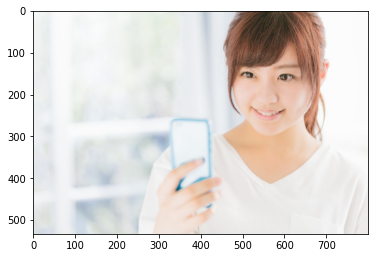

In [4]:
%cd /content/pulse

!rm -rf ./org_img
!mkdir ./org_img
%cd /content/pulse/org_img

image_type ='sample' #@param ['sample', 'upload']
if image_type == 'sample':
  !wget https://www.pakutaso.com/shared/img/thumb/YK0I9A6188_TP_V4.jpg
  file_name = "YK0I9A6188_TP_V4.jpg"
else:
  uploaded = files.upload()
  uploaded = list(uploaded.keys())
  file_name = uploaded[0]


# 低解像度顔画像生成
16x16, 64x64, 128x128の3種を生成

In [5]:
%cd /content/pulse/
# 顔部分を切り出した低解像度画像出力先
img_align_16 = "./img_align_16"
img_align_64 = "./img_align_64"
img_align_128 = "./img_align_128"

!rm -rf {img_align_16}
!rm -rf {img_align_64}
!rm -rf {img_align_128}

# 16x16
!python align_face.py \
  -input_dir ./org_img \
  -output_dir {img_align_16} \
  -output_size 16 \
  -seed 12 \
# 64x64
!python align_face.py \
  -input_dir ./org_img \
  -output_dir {img_align_64} \
  -output_size 64 \
  -seed 12 \
# 128x128
!python align_face.py \
  -input_dir ./org_img \
  -output_dir {img_align_128} \
  -output_size 128 \
  -seed 12 \

/content/pulse
YK0I9A6188_TP_V4.jpg: Number of faces detected: 1
YK0I9A6188_TP_V4.jpg: Number of faces detected: 1
YK0I9A6188_TP_V4.jpg: Number of faces detected: 1


NameError: ignored

## 低解像度顔画像の表示

Text(0.5, 1.0, '128x128')

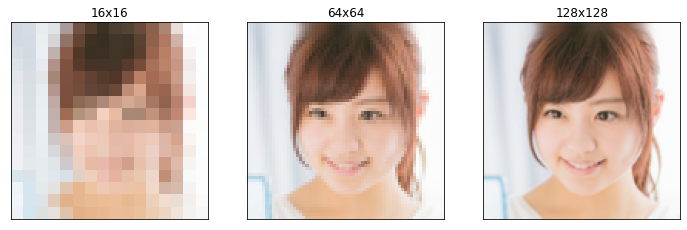

In [14]:
align_16 = glob.glob(img_align_16 + "/*.png") 
image_16 = Image.open(align_16[0]).convert("RGB")
align_64 = glob.glob(img_align_64 + "/*.png") 
image_64 = Image.open(align_64[0]).convert("RGB")
align_128 = glob.glob(img_align_128 + "/*.png") 
image_128 = Image.open(align_128[0]).convert("RGB")

fig = plt.figure(num=None, figsize=(12, 5))
# 16x16
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
plt.imshow(image_16)
ax.set_title("16x16")
# 64x64
ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
plt.imshow(image_64)
ax.set_title("64x64")
# 128x128
ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
plt.imshow(image_128)
ax.set_title("128x128")


# 超解像
16x16, 64x64, 128x128の3種をそれぞれ1024x1024へ変換

In [15]:
%cd /content/pulse/
img_sr_16 = "./img_sr_16"
img_sr_64 = "./img_sr_64"
img_sr_128 = "./img_sr_128"
steps = 500

!rm -rf {img_sr_16}
!rm -rf {img_sr_64}
!rm -rf {img_sr_128}

# 16x16
!python run.py \
  -input_dir {img_align_16} \
  -output_dir {img_sr_16} \
  -duplicates 1 \
  -seed 12 \
  -noise_type trainable \
  -steps {steps} \
  -save_intermediate
# 64x64
!python run.py \
  -input_dir {img_align_64} \
  -output_dir {img_sr_64} \
  -duplicates 1 \
  -seed 12 \
  -noise_type trainable \
  -steps {steps} \
  -save_intermediate
# 128x128
!python run.py \
  -input_dir {img_align_128} \
  -output_dir {img_sr_128} \
  -duplicates 1 \
  -seed 12 \
  -noise_type trainable \
  -steps {steps} \
  -save_intermediate

/content/pulse
Loading Synthesis Network
Optimizing
BEST (500) | L2: 0.0020 | GEOCROSS: 0.1251 | TOTAL: 0.2063 | time: 469.8 | it/s: 1.06 | batchsize: 1
Loading Synthesis Network
Optimizing
BEST (499) | L2: 0.0020 | GEOCROSS: 0.4555 | TOTAL: 0.2228 | time: 486.5 | it/s: 1.03 | batchsize: 1
Loading Synthesis Network
Optimizing
BEST (500) | L2: 0.0020 | GEOCROSS: 0.6635 | TOTAL: 0.2332 | time: 487.5 | it/s: 1.03 | batchsize: 1


## 超解像結果の表示

Text(0.5, 1.0, 'sr 128x128')

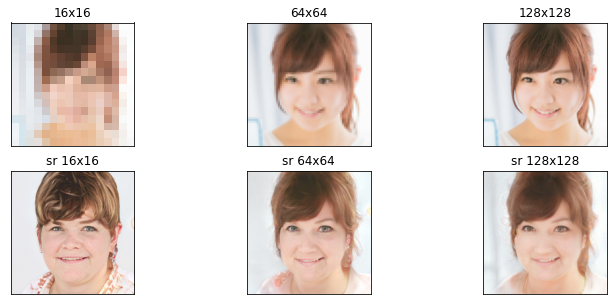

In [16]:
file_name_wo_ext = os.path.splitext(os.path.basename(file_name))[0]
sr_16_file_name = img_sr_16 + "/" + file_name_wo_ext + "_0/HR/" + file_name_wo_ext + "_0_" + str(steps-1) + ".png"
sr_64_file_name = img_sr_64 + "/" + file_name_wo_ext + "_0/HR/" + file_name_wo_ext + "_0_" + str(steps-1) + ".png"
sr_128_file_name = img_sr_128 + "/" + file_name_wo_ext + "_0/HR/" + file_name_wo_ext + "_0_" + str(steps-1) + ".png"
sr_image_16 = Image.open(sr_16_file_name).convert("RGB")
sr_image_64 = Image.open(sr_64_file_name).convert("RGB")
sr_image_128 = Image.open(sr_128_file_name).convert("RGB")


fig = plt.figure(num=None, figsize=(12, 5))
# 16x16
ax = fig.add_subplot(2, 3, 1, xticks=[], yticks=[])
plt.imshow(image_16)
ax.set_title("16x16")
ax = fig.add_subplot(2, 3, 4, xticks=[], yticks=[])
plt.imshow(sr_image_16)
ax.set_title("sr 16x16")
# 64x64
ax = fig.add_subplot(2, 3, 2, xticks=[], yticks=[])
plt.imshow(image_64)
ax.set_title("64x64")
ax = fig.add_subplot(2, 3, 5, xticks=[], yticks=[])
plt.imshow(sr_image_64)
ax.set_title("sr 64x64")
ax = fig.add_subplot(2, 3, 3, xticks=[], yticks=[])
plt.imshow(image_128)
ax.set_title("128x128")
ax = fig.add_subplot(2, 3, 6, xticks=[], yticks=[])
plt.imshow(sr_image_128)
ax.set_title("sr 128x128")

# テスト動画のセットアップ
本レシピで使用している動画は下記です。  
https://pixabay.com/ja/videos/%E6%84%9F%E6%83%85-%E7%94%B7%E6%80%A7%E3%82%92%E8%A6%8B-%E4%BA%BA%E9%96%93-%E4%BA%BA-44440/

In [17]:
%cd /content/pulse
!rm -rf ./origin_video
!mkdir -p ./origin_video/frames
%cd /content/pulse/origin_video

uploaded = files.upload()
uploaded = list(uploaded.keys())
video_name = uploaded[0]

from moviepy.editor import *
from moviepy.video.fx.resize import resize

clip = VideoFileClip(video_name)
# 2~3秒までを切り出し
sub_clip = clip.subclip(2, 3)
sub_clip.write_videofile("src-video.mp4")
video_name = "src-video.mp4"

# 表示用にリサイズ
clip_resize = resize(sub_clip, height=240)
clip_resize.ipython_display()

/content/pulse
/content/pulse/origin_video


Saving Emotions - 44440.mp4 to Emotions - 44440.mp4
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2686976/45929032 bytes (5.9%)6193152/45929032 bytes (13.5%)9510912/45929032 bytes (20.7%)12869632/45929032 bytes (28.0%)16138240/45929032 bytes (35.1%)19767296/45929032 bytes (43.0%)23396352/45929032 bytes (50.9%)27000832/45929032 bytes (58.8%)30646272/45929032 bytes (66.7%)34144256/45929032 bytes (74.3%)37773312/45929032 bytes (82.2%)41508864/

100%|██████████| 23/23 [00:00<00:00, 2245.14it/s]

[MoviePy] Done.
[MoviePy] Writing video src-video.mp4



100%|██████████| 24/24 [00:00<00:00, 261.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: src-video.mp4 



100%|██████████| 24/24 [00:00<00:00, 158.94it/s]


# テスト動画をフレーム分割

In [18]:
!ffmpeg -i {video_name} /content/pulse/origin_video/frames/src-video-frame-%d.png

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

# 低解像度顔画像生成

/content/pulse
src-video-frame-22.png: Number of faces detected: 1
src-video-frame-19.png: Number of faces detected: 1
src-video-frame-23.png: Number of faces detected: 1
src-video-frame-20.png: Number of faces detected: 1
src-video-frame-8.png: Number of faces detected: 1
src-video-frame-13.png: Number of faces detected: 1
src-video-frame-11.png: Number of faces detected: 1
src-video-frame-24.png: Number of faces detected: 1
src-video-frame-21.png: Number of faces detected: 1
src-video-frame-4.png: Number of faces detected: 1
src-video-frame-14.png: Number of faces detected: 1
src-video-frame-18.png: Number of faces detected: 1
src-video-frame-3.png: Number of faces detected: 1
src-video-frame-5.png: Number of faces detected: 1
src-video-frame-6.png: Number of faces detected: 1
src-video-frame-2.png: Number of faces detected: 1
src-video-frame-12.png: Number of faces detected: 1
src-video-frame-16.png: Number of faces detected: 1
src-video-frame-7.png: Number of faces detected: 1
src-

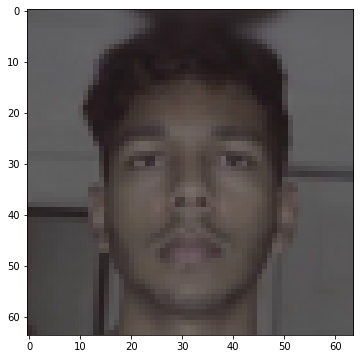

In [19]:
%cd /content/pulse/
# 顔部分を切り出した低解像度画像出力先
video_align_dir = "./video_input_face"

!rm -rf {video_align_dir}

!python align_face.py \
  -input_dir ./origin_video/frames \
  -output_dir {video_align_dir} \
  -output_size 64 \
  -seed 1234 \

video_align_imgs = glob.glob(video_align_dir + "/*.png") 
image = Image.open(video_align_imgs[0]).convert("RGB")
plt.figure(figsize=(6, 6))
plt.imshow(image)

# 超解像(動画)
64x64から1024x1024へ変換

In [20]:
%cd /content/pulse/
sr_video_result = "./sr_video_result"
steps = 20

!rm -rf {sr_video_result}

!python run.py \
  -input_dir {video_align_dir} \
  -output_dir {sr_video_result} \
  -duplicates 1 \
  -seed 30 \
  -noise_type trainable \
  -steps {steps} \
  -save_intermediate

/content/pulse
Loading Synthesis Network
Optimizing
BEST (20) | L2: 0.0077 | GEOCROSS: 30.2504 | TOTAL: 2.2854 | time: 19.4 | it/s: 1.03 | batchsize: 1
Could not find a face that downscales correctly within epsilon
Optimizing
BEST (20) | L2: 0.0075 | GEOCROSS: 31.4640 | TOTAL: 2.3240 | time: 18.8 | it/s: 1.07 | batchsize: 1
Could not find a face that downscales correctly within epsilon
Optimizing
BEST (20) | L2: 0.0076 | GEOCROSS: 31.0677 | TOTAL: 2.3135 | time: 18.9 | it/s: 1.06 | batchsize: 1
Could not find a face that downscales correctly within epsilon
Optimizing
BEST (20) | L2: 0.0076 | GEOCROSS: 30.8985 | TOTAL: 2.3041 | time: 18.8 | it/s: 1.06 | batchsize: 1
Could not find a face that downscales correctly within epsilon
Optimizing
BEST (20) | L2: 0.0075 | GEOCROSS: 31.5283 | TOTAL: 2.3249 | time: 19.1 | it/s: 1.05 | batchsize: 1
Could not find a face that downscales correctly within epsilon
Optimizing
BEST (20) | L2: 0.0076 | GEOCROSS: 31.3482 | TOTAL: 2.3230 | time: 19.0 | it/s

# frame画像を収集
各フレーム画像の超解像結果を一つのディレクトリ配下にコピー

In [21]:
%cd /content/pulse/
sr_video_result_frames = sr_video_result + "/frames"
!mkdir -p {sr_video_result_frames}

results = glob.glob(sr_video_result + "/*/HR/*_0_" + str(steps-1) + ".png")
print(results)

for result in results:
  !cp {result} {sr_video_result_frames}


/content/pulse
['./sr_video_result/src-video-frame-9_0/HR/src-video-frame-9_0_19.png', './sr_video_result/src-video-frame-11_0/HR/src-video-frame-11_0_19.png', './sr_video_result/src-video-frame-8_0/HR/src-video-frame-8_0_19.png', './sr_video_result/src-video-frame-6_0/HR/src-video-frame-6_0_19.png', './sr_video_result/src-video-frame-14_0/HR/src-video-frame-14_0_19.png', './sr_video_result/src-video-frame-20_0/HR/src-video-frame-20_0_19.png', './sr_video_result/src-video-frame-22_0/HR/src-video-frame-22_0_19.png', './sr_video_result/src-video-frame-3_0/HR/src-video-frame-3_0_19.png', './sr_video_result/src-video-frame-21_0/HR/src-video-frame-21_0_19.png', './sr_video_result/src-video-frame-16_0/HR/src-video-frame-16_0_19.png', './sr_video_result/src-video-frame-12_0/HR/src-video-frame-12_0_19.png', './sr_video_result/src-video-frame-24_0/HR/src-video-frame-24_0_19.png', './sr_video_result/src-video-frame-7_0/HR/src-video-frame-7_0_19.png', './sr_video_result/src-video-frame-10_0/HR/sr

# frame画像を動画に変換

In [24]:
src_frames = sr_video_result_frames + "/src-video-frame-%0d_0_" + str(steps-1) + ".png"
dst_video = sr_video_result + "/out.mp4"

!ffmpeg -i {src_frames} -c:v libx264 -vf "fps=25,format=yuv420p" {dst_video}

clip = VideoFileClip(dst_video)

# 表示用にリサイズ
clip_resize = resize(clip, height=480)
clip_resize.ipython_display()

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

 96%|█████████▌| 24/25 [00:00<00:00, 51.33it/s]
